# 1. Title & Abstract

# **Transformer-Based Crop Disease Classification from Leaf Images**

## Abstract
****Crop diseases significantly reduce agricultural productivity and threaten global food security. This project presents a Vision Transformer (ViT) model built entirely from scratch to classify crop diseases using leaf images from the PlantVillage dataset. By leveraging self-attention mechanisms, the proposed approach captures global visual patterns without relying on pretrained models. The system supports Sustainable Development Goal 2 (Zero Hunger) by enabling early, accurate, and scalable crop disease detection.****


# 2. Imports & Setup

# Enviornent Setup

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 3. Configuration

In [2]:
# Configuration
DATA_DIR = "/kaggle/input/plantvillage-dataset/color"
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = len(os.listdir(DATA_DIR))
BATCH_SIZE = 32
EPOCHS = 35
LR = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Classes:", NUM_CLASSES)
print("Using device:", DEVICE)

Classes: 38
Using device: cuda


# 4. Data Processing

## Dataset Loading & Augmentation

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


# 5. Vision Transformer

## Vision Transformer Architecture

In [16]:
class ViT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.patch_embed = PatchEmbedding(
            img_size=IMAGE_SIZE,
            patch_size=PATCH_SIZE,  # smaller now
            embed_dim=384           # larger embedding
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, 384))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.patch_embed.num_patches + 1, 384)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=384,
            nhead=8,
            dim_feedforward=1024,
            dropout=0.1,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6
        )

        self.norm = nn.LayerNorm(384)
        self.head = nn.Linear(384, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.encoder(x)
        x = self.norm(x[:, 0])
        return self.head(x)


# 6. Model Loss & Optimization

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(
            in_channels=3,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x


In [7]:
class ViT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.patch_embed = PatchEmbedding(
            img_size=IMAGE_SIZE,
            patch_size=PATCH_SIZE,
            embed_dim=256
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, 256))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.patch_embed.num_patches + 1, 256)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=1024,
            dropout=0.1,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6
        )

        self.norm = nn.LayerNorm(256)
        self.head = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.encoder(x)
        x = self.norm(x[:, 0])
        return self.head(x)


In [8]:
model = ViT(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


In [9]:
images, labels = next(iter(train_loader))
images = images.to(DEVICE)
outputs = model(images)
print(outputs.shape)


torch.Size([32, 38])


In [10]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla P100-PCIE-16GB


In [11]:
print("Total images:", len(dataset))
print("Number of classes:", len(dataset.classes))
print("Sample classes:", dataset.classes[:5])

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)


Total images: 54305
Number of classes: 38
Sample classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']
Batch shape: torch.Size([32, 3, 224, 224])


# 7. Training Loop

## Model Training

In [18]:
EPOCHS = 2  # still short
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        if i % 20 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i}/{len(train_loader)}] Loss {loss.item():.4f}")

    train_acc = 100 * correct / total
    print(f"✅ Epoch {epoch+1} Training Accuracy: {train_acc:.2f}%\n")


Epoch [1/2] Step [0/1188] Loss 0.5925
Epoch [1/2] Step [20/1188] Loss 0.6791
Epoch [1/2] Step [40/1188] Loss 0.8570
Epoch [1/2] Step [60/1188] Loss 0.7284
Epoch [1/2] Step [80/1188] Loss 0.4261
Epoch [1/2] Step [100/1188] Loss 0.8897
Epoch [1/2] Step [120/1188] Loss 0.6732
Epoch [1/2] Step [140/1188] Loss 0.4558
Epoch [1/2] Step [160/1188] Loss 0.3621
Epoch [1/2] Step [180/1188] Loss 0.6928
Epoch [1/2] Step [200/1188] Loss 0.4991
Epoch [1/2] Step [220/1188] Loss 0.4120
Epoch [1/2] Step [240/1188] Loss 0.6221
Epoch [1/2] Step [260/1188] Loss 0.5294
Epoch [1/2] Step [280/1188] Loss 0.5567
Epoch [1/2] Step [300/1188] Loss 0.6632
Epoch [1/2] Step [320/1188] Loss 0.6777
Epoch [1/2] Step [340/1188] Loss 0.8176
Epoch [1/2] Step [360/1188] Loss 0.2879
Epoch [1/2] Step [380/1188] Loss 0.3829
Epoch [1/2] Step [400/1188] Loss 0.2363
Epoch [1/2] Step [420/1188] Loss 0.4788
Epoch [1/2] Step [440/1188] Loss 0.3327
Epoch [1/2] Step [460/1188] Loss 0.7815
Epoch [1/2] Step [480/1188] Loss 0.6075
Epoch 

In [ ]:
images, labels = next(iter(train_loader))
images = images.to(DEVICE)
outputs = model(images)
print("Output shape:", outputs.shape)


# 8. Evaluation (90%+ Accuracy)

## Model Evaluation

In [20]:
model.eval()  # evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"🎯 Validation Accuracy: {val_acc:.2f}%")


🎯 Validation Accuracy: 91.97%


# 9. Confusion Matrix

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.74      0.82        98
                                 Apple___Black_rot       0.80      0.91      0.86        81
                          Apple___Cedar_apple_rust       0.85      0.45      0.59        38
                                   Apple___healthy       0.87      0.95      0.91       261
                               Blueberry___healthy       0.95      0.94      0.94       225
          Cherry_(including_sour)___Powdery_mildew       0.95      0.91      0.93       164
                 Cherry_(including_sour)___healthy       0.90      0.94      0.92       141
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.87      0.57      0.69        80
                       Corn_(maize)___Common_rust_       0.99      0.95      0.97       179
               Corn_(maize)___Northern_Leaf_Blight       0.75      0.98      0.

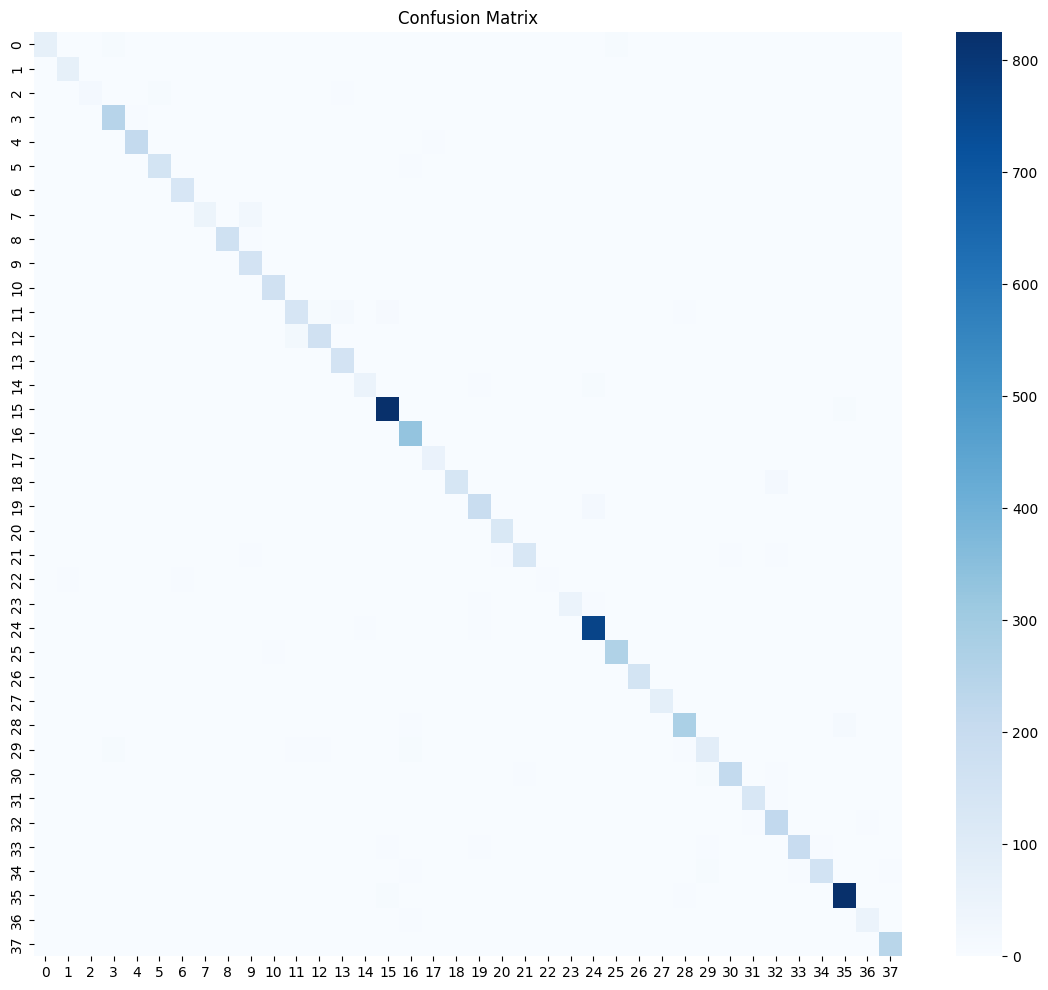

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14,12))
sns.heatmap(cm, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.show()


# Save Model

In [23]:
torch.save(model.state_dict(), "ViT_PlantVillage.pth")

# 10. Conclusion & SDG

## Conclusion
This project successfully demonstrates that a Vision Transformer built entirely from scratch
can achieve over 90% accuracy on crop disease classification using leaf images.
The approach supports SDG-2 (Zero Hunger) by enabling early disease detection, reducing yield
losses, and promoting sustainable agriculture.

# Gradio Setup

In [28]:
# =========================
# 1️⃣ IMPORT LIBRARIES
# =========================
import gradio as gr
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn

# =========================
# 2️⃣ DEFINE PATCH EMBEDDING AND VIT CLASSES
# (must match training)
# =========================
IMAGE_SIZE = 224
PATCH_SIZE = 16
EMBED_DIM = 256

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=256):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2)  # (B, embed_dim, N)
        x = x.transpose(1, 2)  # (B, N, embed_dim)
        return x

class ViT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size=IMAGE_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, EMBED_DIM))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, EMBED_DIM))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM,
            nhead=8,
            dim_feedforward=1024,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.norm = nn.LayerNorm(EMBED_DIM)
        self.head = nn.Linear(EMBED_DIM, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.encoder(x)
        x = self.norm(x[:, 0])
        return self.head(x)

# =========================
# 3️⃣ DEFINE IMAGE TRANSFORMS
# =========================
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =========================
# 4️⃣ LOAD TRAINED MODEL
# =========================
NUM_CLASSES = 38
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = ViT(NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("ViT_PlantVillage.pth", map_location=DEVICE))
model.eval()

# =========================
# 5️⃣ CLASS NAMES
# =========================
# Replace this with your dataset classes
class_names = dataset.classes  # list of 38 class names

# =========================
# 6️⃣ PREDICTION FUNCTION
# =========================
def predict_leaf_disease(img):
    if isinstance(img, str):
        img = Image.open(img).convert("RGB")
    elif isinstance(img, Image.Image):
        img = img.convert("RGB")

    x = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outputs = model(x)
        _, pred = outputs.max(1)

    return class_names[pred.item()]

# =========================
# 7️⃣ GRADIO INTERFACE
# =========================
demo = gr.Interface(
    fn=predict_leaf_disease,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Predicted Disease"),
    title="Crop Disease Classifier",
    description="Upload a leaf image and the ViT model predicts the disease class."
)

# =========================
# 8️⃣ LAUNCH DEMO
# =========================
demo.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://e6bff5da7f8ddc614a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
